In [295]:
import pandas
import seaborn as sns
import numpy as np
%matplotlib inline

In [296]:
sounds = pandas.read_csv('/Users/gilles/Dropbox/Science/bistable_motion_pupil/sounds.csv', index_col=0)
keys = pandas.read_csv('/Users/gilles/Dropbox/Science/bistable_motion_pupil/keys.csv', index_col=0)

In [297]:
def get_intervals(d, no_inbetween=True):
    
    
    d['run_type'] = d['type']
    d['previous_button'] = d.button.shift(1)
    d.loc[:, 'duration'] = (d.EL_timestamp - d.EL_timestamp.shift(1)) / 1000.
    d.loc[(d.button != 3) & (d.previous_button != 3), 'type'] = 'full percept switch'
    d.loc[(d.button != 3) & (d.previous_button == 3), 'type'] = 'ambiguous to full percept'
    d.loc[(d.button == 3), 'type'] = 'full to ambiguous percept'
    d.loc[d.button != 3, 'start'] = d[d.button != 3].EL_timestamp.shift(1)
    d.loc[d.button != 3, 'end'] = d[d.button != 3].EL_timestamp
    
    
    assert(len(d.subject_id.unique()) == 1)
    assert(len(d.session.unique()) == 1)
    
    s = sounds[(sounds.subject_id == d.subject_id.iloc[0]) & (sounds.session == d.session.iloc[0])]
    s_real = s[s.sound_type != 0]
    s_dummy = s[s.sound_type == 0]
    
    d['n_sounds'] = [((s_real.EL_timestamp > row.start) & (s_real.EL_timestamp < row.end)).sum() for ix, row in d.iterrows()]
    d['n_dummy_sounds'] = [((s_dummy.EL_timestamp > row.start) & (s_dummy.EL_timestamp < row.end)).sum() for ix, row in d.iterrows()]
        
    return d[['button', 'previous_button', 'type', 'run_type', 'duration', 'subject_id', 'n_sounds', 'n_dummy_sounds', 'block', 'start', 'end', 'session']]

In [298]:
import seaborn as sns

In [299]:
intervals = keys.groupby(['subject_id', 'session', 'block']).apply(get_intervals)

In [300]:
intervals.head()

,button,previous_button,type,run_type,duration,subject_id,n_sounds,n_dummy_sounds,block,start,end,session
0,2.0,NaN,full percept switch,ambiguous rivalry,NaN,A,0,0,1.0,NaN,6398512.0,1
1,1.0,2.0,full percept switch,ambiguous rivalry,16.085,A,4,4,1.0,6398512.0,6414597.0,1
2,2.0,1.0,full percept switch,ambiguous rivalry,11.292,A,3,3,1.0,6414597.0,6425889.0,1
3,1.0,2.0,full percept switch,ambiguous rivalry,11.759,A,2,1,1.0,6425889.0,6437648.0,1
4,2.0,1.0,full percept switch,ambiguous rivalry,1.051,A,0,0,1.0,6437648.0,6438699.0,1


In [301]:
intervals['total_number_of_sounds'] = intervals['n_dummy_sounds'] + intervals['n_sounds']

In [302]:
intervals['percentage_dummy_sounds'] = intervals['n_dummy_sounds'] / intervals['total_number_of_sounds']

In [303]:
def get_first_keypress(sound, key):
    
    next_key_ix = key.EL_timestamp.searchsorted(sound.EL_timestamp, side='right')
    next_key_ix[next_key_ix > len(key)-1] = -1
    
    sound['time_to_next_key_press'] = key.iloc[next_key_ix].EL_timestamp.values - sound.EL_timestamp.values
    sound['next_key'] = key.iloc[next_key_ix].event_type.values
    sound['previous_key'] = key.iloc[next_key_ix-1].event_type.values
    sound.loc[next_key_ix==0, 'previous_key'] = np.nan
    
    sound.loc[sound['time_to_next_key_press'] < 0, 'next_key'] = np.nan
    sound.loc[sound['time_to_next_key_press'] < 0, 'time_to_next_key_press'] = np.nan
    return sound

In [304]:
keys = pandas.read_csv('/Users/gilles/Dropbox/Science/bistable_motion_pupil/keys.csv', index_col=0)
sounds['time_to_next_key_press'] = np.nan
sounds['next_key'] = np.nan

keys = keys.set_index(['subject_id', 'session', 'block'])

for (sid, session, block, run_type), sound in sounds.groupby(['subject_id', 'session', 'block', 'type']):
    if (sid, session, block) in keys.index:
        key = keys.loc[sid, session, block]

        if len(key) > 0:
            get_first_keypress(sound, key)
            sounds.loc[sound.index, 'time_to_next_key_press'] = sound['time_to_next_key_press']
            sounds.loc[sound.index, 'next_key'] = sound['next_key']
            sounds.loc[sound.index, 'previous_key'] = sound['previous_key']

/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

In [305]:
def get_trial_type(row):
    
    if np.in1d(row.previous_key, [1,2]) & np.in1d(row.next_key, [1,2]):
        return 'full percept switch'
    elif np.in1d(row.previous_key, [1,2]) & (row.next_key == 3):
        return 'full to ambiguous percept'
    elif np.in1d(row.next_key, [1,2]) & (row.previous_key == 3):
        return 'ambiguous to full percept'

In [306]:
sounds.head()

,EL_timestamp,sound_type,block,type,session,subject_id,time_to_next_key_press,next_key,previous_key
0,6022200.0,0.0,0.0,baseline sound,1,A,NaN,NaN,NaN
1,6023766.0,3.0,0.0,baseline sound,1,A,NaN,NaN,NaN
2,6035392.0,0.0,0.0,baseline sound,1,A,NaN,NaN,NaN
3,6036576.0,1.0,0.0,baseline sound,1,A,NaN,NaN,NaN
4,6037609.0,0.0,0.0,baseline sound,1,A,NaN,NaN,NaN


In [307]:
sounds['trial_type'] = sounds.apply(get_trial_type, 1)

In [308]:
sounds['sound'] = sounds.sound_type != 0.0

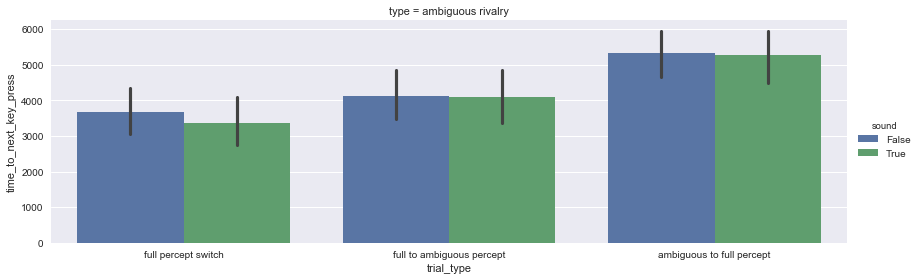

In [309]:
sns.factorplot('trial_type', 'time_to_next_key_press', 'sound', data=sounds[(sounds.type == 'ambiguous rivalry') & (sounds.time_to_next_key_press < 20000)], row='type', kind='bar', aspect=3, units='subject_id')

/Users/gilles/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


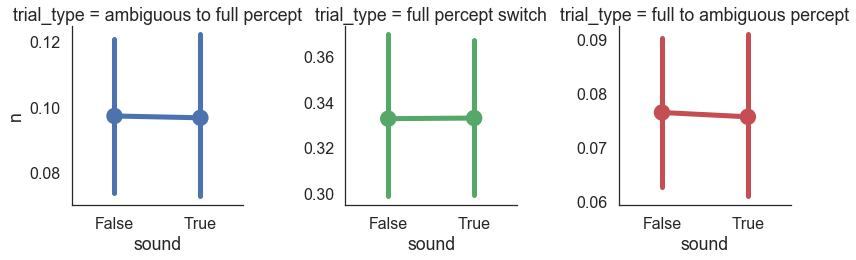

In [418]:
tmp = sounds.groupby(['subject_id', 'sound', 'trial_type']).size().to_frame('n')
tmp = (tmp / tmp.groupby(level=0).sum()).reset_index()
sns.factorplot('sound', 'n', 'trial_type', data=tmp, col='trial_type', sharey=False)

In [395]:
tmp = sounds[(sounds.type == 'ambiguous rivalry')].pivot_table(index='subject_id', columns=['sound', 'trial_type'], values='time_to_next_key_press', aggfunc=np.median)

In [396]:
import scipy as sp

In [397]:
sp.stats.ttest_1samp(tmp[~tmp.isnull().any(1)][False] - tmp[~tmp.isnull().any(1)][True], 0)

Ttest_1sampResult(statistic=array([-0.09960065,  2.45029344,  0.49471001]), pvalue=array([ 0.92137108,  0.02078264,  0.62466443]))

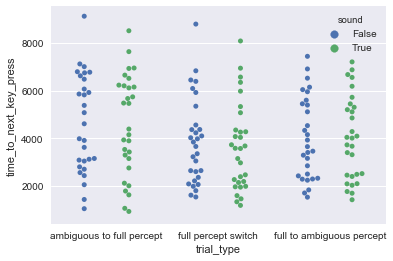

In [313]:
tmp = sounds[(sounds.type == 'ambiguous rivalry') & (sounds.time_to_next_key_press < 20000)].groupby(['subject_id', 'sound', 'trial_type'], as_index=False).mean()
sns.swarmplot('trial_type', 'time_to_next_key_press', 'sound', tmp, split=True, )

/Users/gilles/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


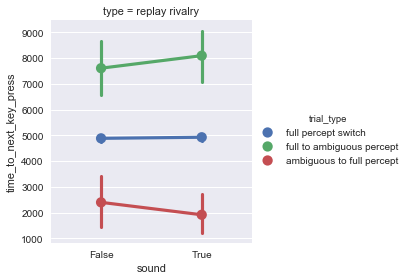

In [314]:
sns.factorplot('sound', 'time_to_next_key_press', 'trial_type', data=sounds[(sounds.type == 'replay rivalry') & (sounds.time_to_next_key_press < 20000)], row='type')

/Users/gilles/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


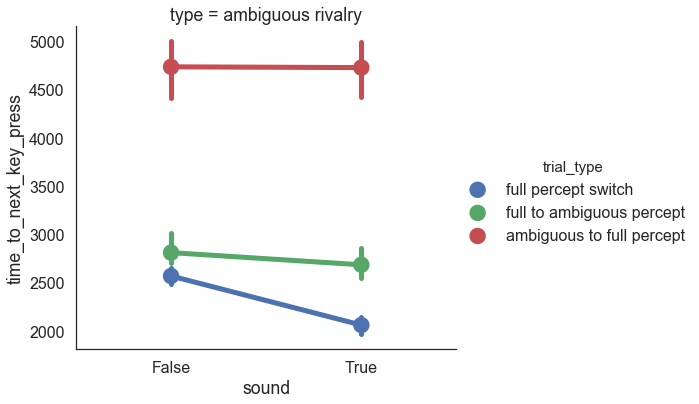

In [387]:
sns.factorplot('sound', 'time_to_next_key_press', 'trial_type', data=sounds[(sounds.type == 'ambiguous rivalry')], row='type', estimator=np.median, aspect=1.2, size=6)

In [401]:
sounds[(sounds.type == 'ambiguous rivalry')].groupby(['trial_type', 'sound']).median().time_to_next_key_press

trial_type                 sound
ambiguous to full percept  False    4733.0
                           True     4725.0
full percept switch        False    2567.0
                           True     2059.0
full to ambiguous percept  False    2809.0
                           True     2683.0
Name: time_to_next_key_press, dtype: float64

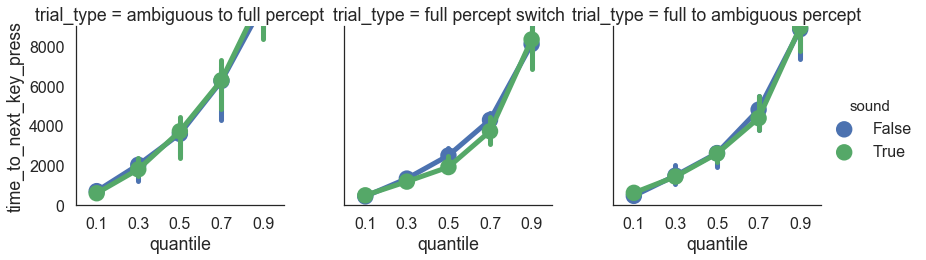

In [402]:
tmp = sounds[(sounds.type == 'ambiguous rivalry') & (sounds.time_to_next_key_press < 20000)].groupby(['subject_id', 'sound', 'trial_type']).time_to_next_key_press.quantile([.1, .3, .5, .7, .9]).reset_index().rename(columns={'level_3':'quantile'})
fac = sns.factorplot('quantile', 'time_to_next_key_press', 'sound', data=tmp, kind='point', split=True, col='trial_type', units='subject_id', ci=67, estimator=np.median)
for ax in fac.axes.ravel():
    ax.set_ylim(0, 9000)

In [404]:
tmp = sounds[~sounds.time_to_next_key_press.isnull() & (sounds.trial_type == 'full percept switch')]
tmp['cdf'] = tmp.groupby(['subject_id', 'sound']).time_to_next_key_press.rank(pct=True)

/Users/gilles/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [405]:
sns.set_context('poster')
sns.set_style('white')

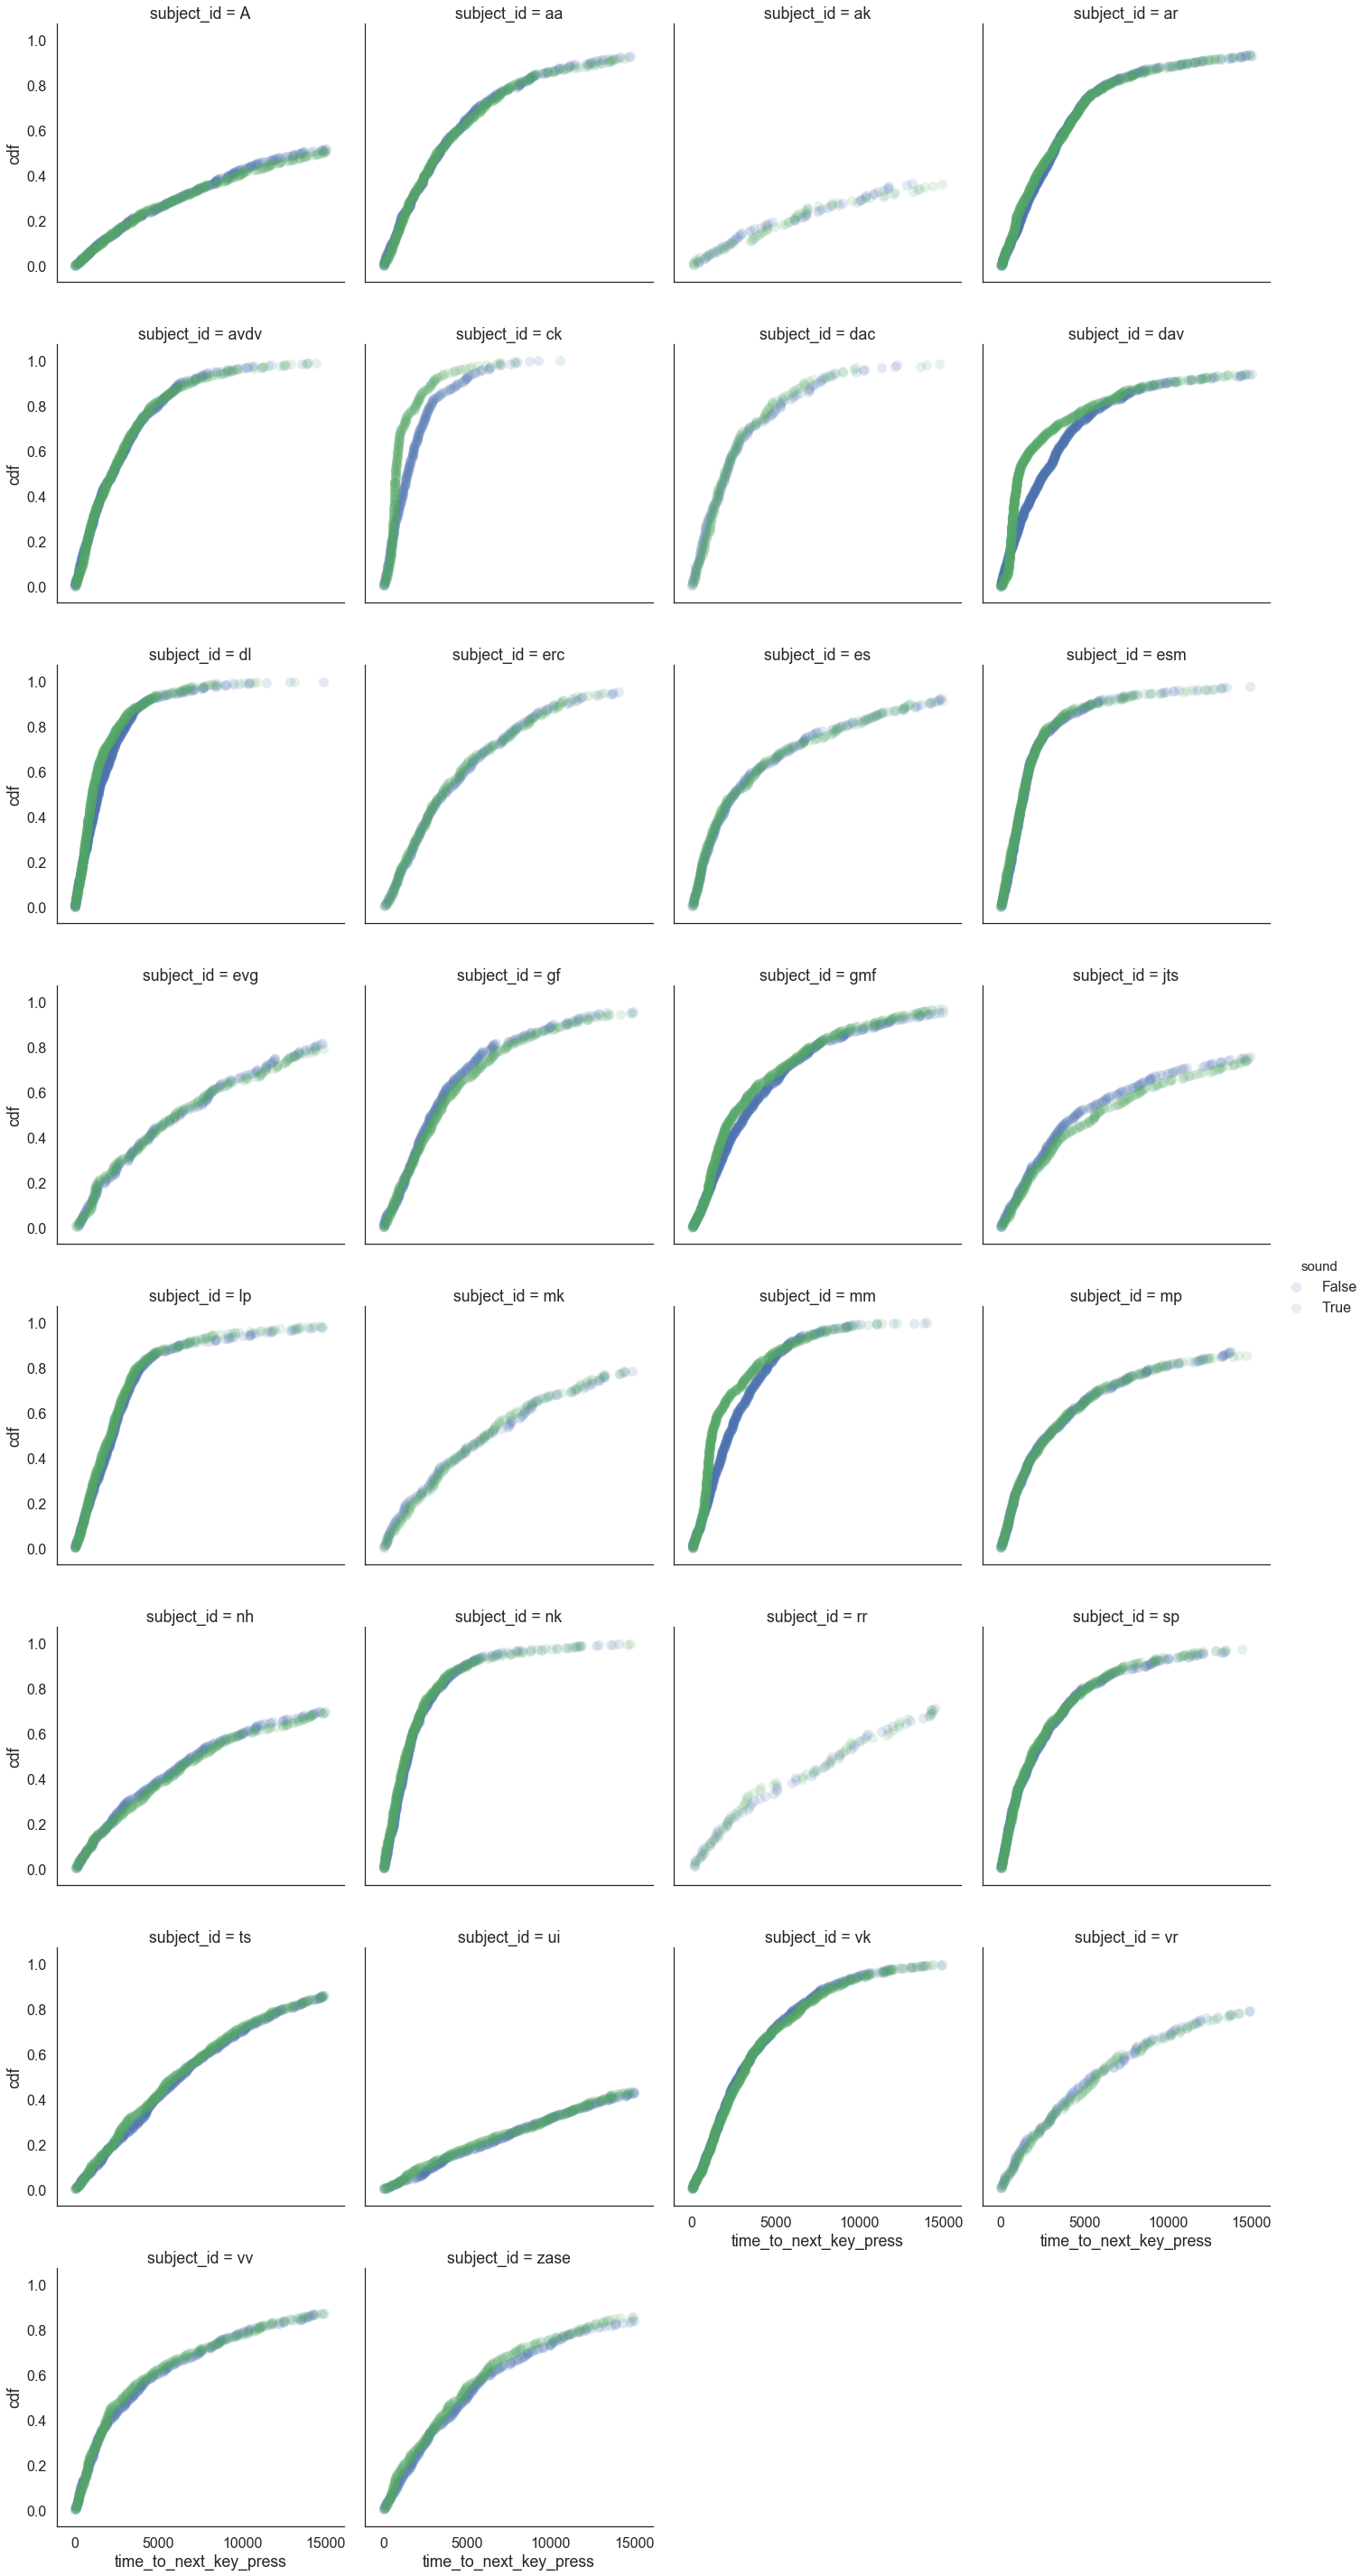

In [406]:
sns.lmplot('time_to_next_key_press', 'cdf', hue='sound', data=tmp[tmp.time_to_next_key_press < 15000], logistic=True, scatter=True, units='subject_id', col='subject_id', col_wrap=4, fit_reg=False, scatter_kws={'alpha':.15})

plt.savefig('individual_cdfs.pdf')